# Calculating change over time


## imports


In [180]:
import leafmap
import leafmap.colormaps as cm
import requests
import rasterio as rio
from rasterio.merge import merge
import glob
from rasterio.plot import reshape_as_image

## searching for data


In [181]:
url = "https://earth-search.aws.element84.com/v1/"
collection = "sentinel-2-l2a"
time_range = "2023-08-01/2023-08-31"

In [182]:
# bbox for dallas metro
bbox = [
    -97.06213756027009,
    32.97324551867027,
    -96.46807822577594,
    33.3578329610085,
]

In [183]:
search_gdf = leafmap.stac_search(
    url=url,
    max_items=10,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
    sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    get_gdf=True,
)

In [184]:
search_gdf.columns

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'proj:epsg', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:dark_features_percentage', 's2:cloud_shadow_percentage',
       's2:vegetation_percentage', 's2:not_vegetated_percentage',
       's2:water_percentage', 's2:unclassified_percentage',
       's2:medium_proba_clouds_percentage', 's2:high_proba_clouds_percentage',
       's2:thin_cirrus_percentage', 's2:snow_ice_percentage',
       's2:product_type', 's2:processing_baseline', 's2:product_uri',
       's2:generation_time', 's2:datatake_id', 's2:datatake_type',
       's2:datastrip_id', 's2:granule_id', 's2:reflectance_conversion_factor',
       'datetime', 's2:sequence', 'earthsearch:s3_path',
       'earthsearch:payload_id', 'ear

## exploring and filtering search results


<Axes: >

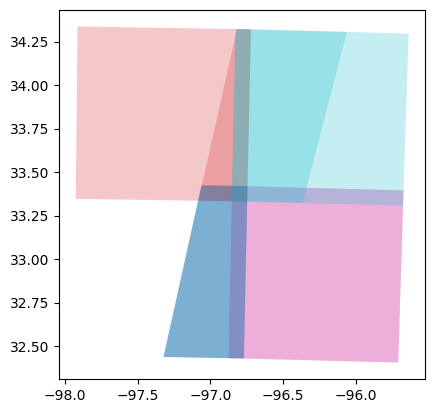

In [185]:
search_gdf.plot("mgrs:grid_square", alpha=0.25)

In [186]:
search_gdf["s2:granule_id"].value_counts()

s2:granule_id
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SQB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A042394_T14SQB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A042580_T14SPC_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SPB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A042537_T14SPB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A042537_T14SQB_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SPC_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A042580_T14SQC_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A042394_T14SPB_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SQC_N05.09    1
Name: count, dtype: int64

In [187]:
search_gdf["area"] = search_gdf.geometry.area

In [188]:
search_gdf.sort_values("area", ascending=False, inplace=True)

In [189]:
search_gdf

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,area
2,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-08-18T06:10:25.042Z,sentinel-2a,sentinel-2,[msi],0.006437,32614,14,S,PC,...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:31.907000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a898...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:10:25.042Z,1.174444
9,"POLYGON ((-96.81576 34.32217, -96.82780 34.277...",2023-08-20T04:44:38.807Z,sentinel-2b,sentinel-2,[msi],0.076934,32614,14,S,QC,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:31.780000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/2524...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:44:38.807Z,1.172798
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-20T04:40:37.325Z,sentinel-2b,sentinel-2,[msi],0.004539,32614,14,S,QB,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:46.266000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/a707...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:40:37.325Z,1.161135
1,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-05T04:59:04.872Z,sentinel-2a,sentinel-2,[msi],0.005262,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A0423...,0.970632,2023-08-04T17:14:46.231000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/73a7...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-05T04:59:04.872Z,1.161135
5,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-15T04:10:46.325Z,sentinel-2a,sentinel-2,[msi],0.014575,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:46.612000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/cac3...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:10:46.325Z,1.161135
7,"POLYGON ((-96.82664 34.32236, -96.85153 33.333...",2023-08-18T06:09:55.100Z,sentinel-2a,sentinel-2,[msi],0.040440,32614,14,S,QC,...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:28.416000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/c613...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:09:55.100Z,0.620451
4,"POLYGON ((-97.06177 33.42442, -97.32332 32.437...",2023-08-15T04:07:22.379Z,sentinel-2a,sentinel-2,[msi],0.014211,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:49.390000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ccee...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:07:22.379Z,0.432199
8,"POLYGON ((-97.05919 33.42438, -97.32056 32.437...",2023-08-05T04:52:48.750Z,sentinel-2a,sentinel-2,[msi],0.059570,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A0423...,0.970632,2023-08-04T17:14:49.014000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a5ff...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-05T04:52:48.750Z,0.429551
3,"POLYGON ((-97.05790 33.42436, -97.31949 32.437...",2023-08-20T04:36:25.463Z,sentinel-2b,sentinel-2,[msi],0.009056,32614,14,S,PB,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:49.046000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ee80...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:36:25.463Z,0.428386
6,"POLYGON ((-96.81576 34.32217, -97.08134 33.336...",2023-08-20T04:30:59.255Z,sentinel-2b,sentinel-2,[msi],0.017386,32614,14,S,PC,...,S2B_OPER_MSI

In [190]:
search_gdf.drop_duplicates("mgrs:grid_square", inplace=True)

<Axes: >

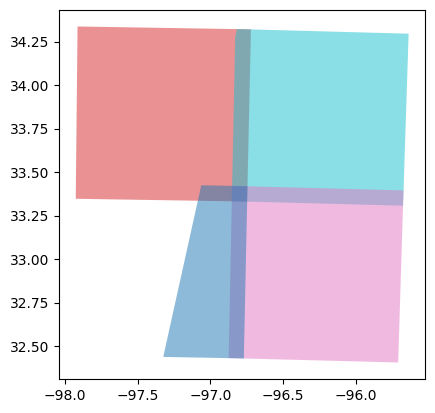

In [191]:
search_gdf.iloc[0:4].plot("s2:granule_id", alpha=0.5)

In [192]:
# # create a query searching for unique datastrip ids based on the above
q = {"s2:granule_id": {"in": search_gdf["s2:granule_id"].iloc[0:4].unique().tolist()}}

search_gdf2 = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_gdf=True,
)

In [193]:
search_gdf2

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-20T04:40:37.325Z,sentinel-2b,sentinel-2,[msi],0.004539,32614,14,S,QB,...,S2B_OPER_MSI_L2A_DS_2BPS_20230819T223356_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:46.266000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/a707...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:40:37.325Z
1,"POLYGON ((-96.81576 34.32217, -96.82780 34.277...",2023-08-20T04:44:38.807Z,sentinel-2b,sentinel-2,[msi],0.076934,32614,14,S,QC,...,S2B_OPER_MSI_L2A_DS_2BPS_20230819T223356_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:31.780000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/2524...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:44:38.807Z
2,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-08-18T06:10:25.042Z,sentinel-2a,sentinel-2,[msi],0.006437,32614,14,S,PC,...,S2A_OPER_MSI_L2A_DS_2APS_20230818T002256_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:31.907000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a898...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:10:25.042Z
3,"POLYGON ((-97.06177 33.42442, -97.32332 32.437...",2023-08-15T04:07:22.379Z,sentinel-2a,sentinel-2,[msi],0.014211,32614,14,S,PB,...,S2A_OPER_MSI_L2A_DS_2APS_20230815T002553_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:49.390000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ccee...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:07:22.379Z


<Axes: >

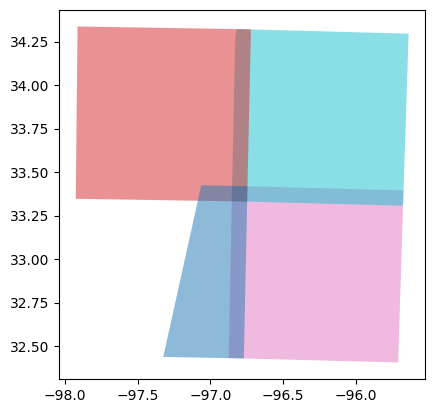

In [194]:
search_gdf2.plot("mgrs:grid_square", alpha=0.5)

### plot to accentuate paved and non-paved divide


In [195]:
search_gdf2_list = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_links=True,
)

In [196]:
m = leafmap.Map()

for layer in search_gdf2_list:
    m.add_stac_layer(layer, bands=["nir", "red", "green"], name=layer.split("/")[-1])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### download files for analysis


In [197]:
def get_raster_band_urls(item: str, bands: list | None = None):
    available_bands = leafmap.stac_bands(item)
    stac = requests.get(item).json()
    band_urls = {
        x: stac["assets"][x]["href"]
        for x in available_bands
        if stac["assets"][x]["href"].startswith("http")
    }

    # if bands, only return bands in list
    if bands:
        band_urls = {x: band_urls[x] for x in bands if x in band_urls}

    return band_urls


def download_stac_layers(layers, out_dir, bands=None):
    for layer in layers:
        band_urls = get_raster_band_urls(layer, bands)
        for band, url in band_urls.items():
            print(url)
            out_file = f"{out_dir}/{layer.split('/')[-1]}_{band}.tif"
            leafmap.download_file(url, out_file, overwrite=False)


def get_stac_crs(item):
    stac = requests.get(item).json()
    return stac["properties"]["proj:epsg"]

In [198]:
stac_crs = get_stac_crs(search_gdf2_list[0])

In [199]:
download_stac_layers(
    search_gdf2_list,
    "../Data/stac/dallas",
)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/AOT.tif
../Data/stac/dallas/S2B_14SQB_20230819_0_L2A_aot.tif already exists. Skip downloading. Set overwrite=True to overwrite.
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B02.tif
../Data/stac/dallas/S2B_14SQB_20230819_0_L2A_blue.tif already exists. Skip downloading. Set overwrite=True to overwrite.
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B01.tif
../Data/stac/dallas/S2B_14SQB_20230819_0_L2A_coastal.tif already exists. Skip downloading. Set overwrite=True to overwrite.
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B03.tif
../Data/stac/dallas/S2B_14SQB_20230819_0_L2A_green.tif already exists. Skip downloading. Set overwrite=True to overwrite.
https://sentinel-cogs.s3.us-west-2.amazon

In [200]:
# mosaic files based on band name


def mosaic_by_band(
    dir,
    bands: list = [
        "red",
        "blue",
        "green",
        "nir",
        "coastal",
        "nir08",
        "nir09",
        "rededge1",
        "rededge2",
        "rededge3",
        "scl",
        "swir16",
        "swir22",
    ],
    crs: str = None,
):
    mosaics = {}
    for band in bands:
        files = glob.glob(f"{dir}/*{band}.tif")

        out_file = f"{dir}/mosaic_{band}_.tif"
        raster_data = [rio.open(f) for f in files]

        mosaic, out_trans = merge(raster_data)
        out_meta = raster_data[0].meta.copy()
        out_meta.update(
            {
                "driver": "GTiff",
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_trans,
                "crs": f"epsg:{crs}",
            }
        )

        with rio.open(out_file, "w", **out_meta) as dest:
            dest.write(mosaic)

        mosaics[band] = out_file

    return mosaics

In [201]:
mosaic_bands_all = mosaic_by_band("../Data/stac/dallas", crs=stac_crs)

In [202]:
mosaic_bands_all

{'red': '../Data/stac/dallas/mosaic_red_.tif',
 'blue': '../Data/stac/dallas/mosaic_blue_.tif',
 'green': '../Data/stac/dallas/mosaic_green_.tif',
 'nir': '../Data/stac/dallas/mosaic_nir_.tif',
 'coastal': '../Data/stac/dallas/mosaic_coastal_.tif',
 'nir08': '../Data/stac/dallas/mosaic_nir08_.tif',
 'nir09': '../Data/stac/dallas/mosaic_nir09_.tif',
 'rededge1': '../Data/stac/dallas/mosaic_rededge1_.tif',
 'rededge2': '../Data/stac/dallas/mosaic_rededge2_.tif',
 'rededge3': '../Data/stac/dallas/mosaic_rededge3_.tif',
 'scl': '../Data/stac/dallas/mosaic_scl_.tif',
 'swir16': '../Data/stac/dallas/mosaic_swir16_.tif',
 'swir22': '../Data/stac/dallas/mosaic_swir22_.tif'}

In [203]:
nir = rio.open(mosaic_bands_all["nir"]).read(1).astype("float32")
red = rio.open(mosaic_bands_all["red"]).read(1).astype("float32")

### calculate NDVI


In [204]:
ndvi = (nir - red) / (nir + red)

In [205]:
import numpy as np

In [206]:
# fill nan with -2, outside of the range but not so far outside
ndvi[np.isnan(ndvi)] = -1.1

In [207]:
ndvi

array([[ 0.3274692 ,  0.3274692 ,  0.3274692 , ...,  0.7303442 ,
         0.76319176,  0.77117   ],
       [ 0.3274692 ,  0.3274692 ,  0.3274692 , ...,  0.7558475 ,
         0.7614915 ,  0.76831234],
       [ 0.3274692 ,  0.3274692 ,  0.3274692 , ...,  0.75866497,
         0.7780662 ,  0.7763371 ],
       ...,
       [-1.1       , -1.1       , -1.1       , ...,  0.28754655,
         0.29281315,  0.29498464],
       [-1.1       , -1.1       , -1.1       , ...,  0.29339352,
         0.28872368,  0.29512894],
       [-1.1       , -1.1       , -1.1       , ...,  0.29570553,
         0.2825    ,  0.2805515 ]], dtype=float32)

In [208]:
ndvi_mult = ndvi * 10  # to be able to visualize more easily

In [209]:
ndvi_mult

array([[  3.274692 ,   3.274692 ,   3.274692 , ...,   7.303442 ,
          7.6319175,   7.7117004],
       [  3.274692 ,   3.274692 ,   3.274692 , ...,   7.558475 ,
          7.614915 ,   7.6831236],
       [  3.274692 ,   3.274692 ,   3.274692 , ...,   7.58665  ,
          7.780662 ,   7.763371 ],
       ...,
       [-11.       , -11.       , -11.       , ...,   2.8754654,
          2.9281316,   2.9498463],
       [-11.       , -11.       , -11.       , ...,   2.9339352,
          2.8872368,   2.9512894],
       [-11.       , -11.       , -11.       , ...,   2.9570553,
          2.825    ,   2.8055148]], dtype=float32)

In [210]:
ndvi_image = leafmap.array_to_image(ndvi, source=mosaic_bands_all["nir"])

In [211]:
ndvi_multi_image = leafmap.array_to_image(ndvi_mult, source=mosaic_bands_all["nir"])

In [212]:
m = leafmap.Map()
m.add_raster(ndvi_multi_image, layer_name="NDVI", vmin=-10, vmax=10, cmap="PiYG")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

(array([1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 3.0000000e+00, 2.3000000e+01,
        5.1000000e+01, 1.1500000e+02, 1.6900000e+02, 2.6000000e+02,
        3.7300000e+02, 5.4800000e+02, 7.8100000e+02, 1.1400000e+03,
        2.1220000e+03, 3.5260000e+03, 4.1920000e+03, 6.2560000e+03,
        9.0690000e+03, 1.1939000e+04, 1.4623000e+04, 2.5026000e+04,
        4.5841000e+04, 5.6715000e+04, 7.4501000e+04, 1.1549700e+05,
        1.5755500e+05, 2.3552200e+05, 3.2187900e+05, 4.0848100e+05,
        5.1592800e+05, 6.7813300e+05, 8.2407800e+05, 9.9234300e+05,
        1.1705310e+06, 1.2067610e+06, 9.5766400e+05, 7.1196200e+05,
        6.6800000e+05, 5.9224800e+05, 3.7914600e+05, 3.6113400e+05,
        3.6551800e+05, 5.3938400e+05, 7.7683000e+05, 9.7845800e+05,
        1.2501920e+06, 1.5167980e+06, 1.7806160e+06, 2.1710810e+06,
        2.8675480e+06, 4.1374880e+06, 5.4322190e

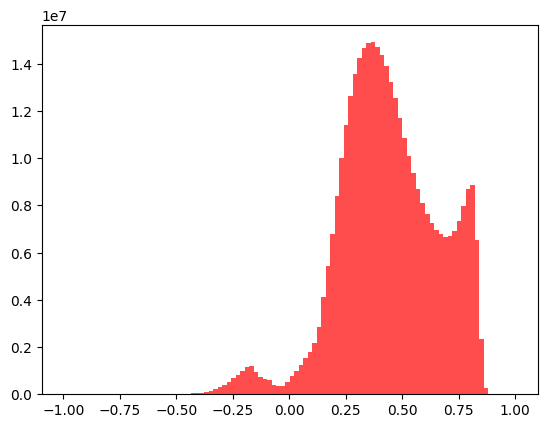

In [213]:
# get histogram of ndvi image values

import matplotlib.pyplot as plt

plt.hist(ndvi[ndvi != -1.1].ravel(), bins=100, color="red", alpha=0.7)

In [214]:
def categorize_np_array(array):

    cat_array = np.zeros(array.shape)
    cat_array[array < 1] = 5
    cat_array[array < 0.8] = 4
    cat_array[array < 0.6] = 3
    cat_array[array < 0.4] = 2
    cat_array[array < 0.2] = 1

    return cat_array

In [215]:
cat_ndvi = categorize_np_array(ndvi)

In [216]:
cat_ndvi

array([[2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       ...,
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.]])

In [217]:
ndvi_image_cat = leafmap.array_to_image(cat_ndvi, source=mosaic_bands_all["nir"])

In [218]:
m = leafmap.Map()
m.add_raster(
    ndvi_image_cat, layer_name="NDVI", vmin=1, vmax=5, cmap="Set1", draw_control=False
)
m.add_colormap(
    "Set1",
    label="ndvi",
    width=8.0,
    height=0.4,
    orientation="horizontal",
    vmin=1,
    vmax=5,
)

m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## k-means


In [219]:
def resample_raster(in_file, out_file, upscale_factor=0.5):
    with rio.open(in_file) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor),
            ),
            resampling=rio.enums.Resampling.bilinear,
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]), (dataset.height / data.shape[-2])
        )

        # update metadata
        meta = dataset.meta.copy()
        meta.update(
            {
                "height": data.shape[1],
                "width": data.shape[2],
                "transform": transform,
            }
        )

        with rio.open(out_file, "w", **meta) as dst:
            dst.write(data)

In [220]:
for band in mosaic_bands_all.keys():
    print(band, rio.open(mosaic_bands_all[band]).read(1).shape)

red (20982, 20976)
blue (20982, 20976)
green (20982, 20976)
nir (20982, 20976)
coastal (3497, 3496)
nir08 (10491, 10488)
nir09 (3497, 3496)
rededge1 (10491, 10488)
rededge2 (10491, 10488)
rededge3 (10491, 10488)
scl (10491, 10488)
swir16 (10491, 10488)
swir22 (10491, 10488)


In [221]:
# set resampling ratio for each band- note that some are higher resolution than others and need a different scaling factor
bands_to_resample = {
    "red": 0.25,
    "blue": 0.25,
    "green": 0.25,
    "nir": 0.25,
    "nir08": 0.5,
    "rededge1": 0.5,
    "rededge2": 0.5,
    "rededge3": 0.5,
    "scl": 0.5,
    "swir16": 0.5,
    "swir22": 0.5,
}

In [222]:
# resample the bands so they are all smaller and uniform
for band, ratio in bands_to_resample.items():
    resample_raster(
        mosaic_bands_all[band], f"../Data/stac/dallas/upscaled_{band}.tif", ratio
    )
    mosaic_bands_all[f"{band}"] = f"../Data/stac/dallas/upscaled_{band}.tif"

In [223]:
mosaic_bands_all

{'red': '../Data/stac/dallas/upscaled_red.tif',
 'blue': '../Data/stac/dallas/upscaled_blue.tif',
 'green': '../Data/stac/dallas/upscaled_green.tif',
 'nir': '../Data/stac/dallas/upscaled_nir.tif',
 'coastal': '../Data/stac/dallas/mosaic_coastal_.tif',
 'nir08': '../Data/stac/dallas/upscaled_nir08.tif',
 'nir09': '../Data/stac/dallas/mosaic_nir09_.tif',
 'rededge1': '../Data/stac/dallas/upscaled_rededge1.tif',
 'rededge2': '../Data/stac/dallas/upscaled_rededge2.tif',
 'rededge3': '../Data/stac/dallas/upscaled_rededge3.tif',
 'scl': '../Data/stac/dallas/upscaled_scl.tif',
 'swir16': '../Data/stac/dallas/upscaled_swir16.tif',
 'swir22': '../Data/stac/dallas/upscaled_swir22.tif'}

In [224]:
# create a new dict with all bands excpct coastal
mosaic_bands_all_no_coastal = {
    k: v for k, v in mosaic_bands_all.items() if k not in ["coastal", "nir09"]
}

In [225]:
for band in mosaic_bands_all_no_coastal.keys():
    print(band, rio.open(mosaic_bands_all_no_coastal[band]).read(1).shape)

mosaic_bands_all_no_coastal = np.stack(
    [
        rio.open(mosaic_bands_all_no_coastal[band]).read(1)
        for band in mosaic_bands_all_no_coastal.keys()
    ],
    axis=-1,
)

red (5245, 5244)
blue (5245, 5244)
green (5245, 5244)
nir (5245, 5244)
nir08 (5245, 5244)
rededge1 (5245, 5244)
rededge2 (5245, 5244)
rededge3 (5245, 5244)
scl (5245, 5244)
swir16 (5245, 5244)
swir22 (5245, 5244)


In [226]:
reshaped_img = reshape_as_image(mosaic_bands_all_no_coastal)

In [227]:
reshaped_img.shape

(5244, 11, 5245)

In [228]:
mosaic_bands_all_no_coastal.shape

(5245, 5244, 11)

In [229]:
from sklearn.cluster import KMeans

rows, cols, bands = mosaic_bands_all_no_coastal.shape

k = 10  # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(
    mosaic_bands_all_no_coastal.reshape(rows * cols, bands)
)

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

In [230]:
# plot prediction results

m = leafmap.Map()
m.add_raster(
    leafmap.array_to_image(kmeans_predictions_2d, source=mosaic_bands_all["red"]),
    layer_name="KMeans",
    colormap="Set1",
    draw_control=False,
)

# add a legend
m.add_colormap(
    "Set1",
    label="KMeans",
    width=8.0,
    height=0.4,
    orientation="horizontal",
    vmin=0,
    vmax=9,
)

m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## classify using samples


In [231]:
import geopandas as gpd

In [232]:
# use a random forest classifier to classify the image using samples from the geojson dataset
samples = gpd.read_file("./data.geojson")

samples

,type,geometry
0,None,None
1,golf,"POLYGON ((-96.90516 33.04001, -96.90676 33.038..."
2,wetland,"POLYGON ((-96.88824 33.05067, -96.88980 33.049..."
3,industrial,"POLYGON ((-96.91752 33.05633, -96.91691 33.055..."
4,deep water,"POLYGON ((-96.93657 33.07736, -96.93907 33.074..."
...,...,...
74,urban,"POLYGON ((-96.66727 32.79627, -96.66489 32.795..."
75,urban,"POLYGON ((-96.66537 32.79916, -96.66544 32.797..."
76,urban,"POLYGON ((-96.67495 32.79557, -96.67499 32.794..."
77,urban,"POLYGON ((-96.67810 32.79755, -96.67817 32.796..."


In [233]:
from sklearn.ensemble import RandomForestClassifier

In [234]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# create matricies for the classifier by loading in the mosaic bands and creating a multiband array
mosaic_data = np.stack(
    [rio.open(mosaic_bands[band]).read(1) for band in ["nir", "red", "green", "blue"]],
    axis=-1,
)

# reshape the data to be 2d
X = mosaic_data.reshape(-1, 4)

In [235]:
X

array([[2641, 1338,  908,  648],
       [2641, 1338,  922,  672],
       [2641, 1338,  992,  714],
       ...,
       [3168, 1722, 1274,  952],
       [3078, 1722, 1270,  916],
       [3065, 1722, 1208,  924]], dtype=uint16)

In [236]:
samples_diss = samples.dissolve(by="type").reset_index()

In [237]:
samples["class"] = samples["type"].astype("category").cat.codes

In [238]:
samples["class"].unique()

array([-1,  3, 11,  4,  1,  7,  6,  0,  2,  8,  9, 10,  5], dtype=int8)

In [239]:
ref_raster = rio.open(mosaic_bands_all["nir"])

In [240]:
samples.geometry.dropna(inplace=True)

In [241]:
ref_raster.transform

Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 3800040.0)

In [242]:
ref_raster.crs

CRS.from_epsg(32614)

In [243]:
samples.to_crs(ref_raster.crs, inplace=True)

In [244]:
samples.dropna(inplace=True)

In [245]:
samples["class"].unique()

array([ 3, 11,  4,  1,  7,  6,  0,  2,  8,  9, 10,  5], dtype=int8)

In [246]:
# print each value pair in geom_value
for geom, value in zip(samples.geometry, samples["class"]):
    print(type(geom), value)

<class 'shapely.geometry.polygon.Polygon'> 3
<class 'shapely.geometry.polygon.Polygon'> 11
<class 'shapely.geometry.polygon.Polygon'> 4
<class 'shapely.geometry.polygon.Polygon'> 1
<class 'shapely.geometry.polygon.Polygon'> 7
<class 'shapely.geometry.polygon.Polygon'> 6
<class 'shapely.geometry.polygon.Polygon'> 0
<class 'shapely.geometry.polygon.Polygon'> 0
<class 'shapely.geometry.polygon.Polygon'> 2
<class 'shapely.geometry.polygon.Polygon'> 11
<class 'shapely.geometry.polygon.Polygon'> 2
<class 'shapely.geometry.polygon.Polygon'> 6
<class 'shapely.geometry.polygon.Polygon'> 6
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 8
<class 'shapely.geometry.polygon.Polygon'> 9
<class '

In [247]:
samples.crs

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [248]:
geom_value = (
    (geom, value) for geom, value in zip(samples["geometry"], samples["class"])
)

# geom = [g for g, v in geom_value if g is not None]

# Rasterize vector using the shape and transform of the raster
rasterized = rio.features.rasterize(
    geom_value,
    out_shape=ref_raster.shape,
    transform=ref_raster.transform,
    all_touched=True,
    fill=-2,  # background value
    # default_value=1,
    merge_alg=rio.enums.MergeAlg.replace,
    dtype=np.int16,
)

# geom_value,
# out_shape = raster.shape,
# transform = raster.transform,
# all_touched = True,
# fill = -5,   # background value
# merge_alg = MergeAlg.replace,
# dtype = int16)

In [249]:
# get uniqe values in the rasterized array
np.unique(rasterized)

array([-2,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int16)

In [250]:
samples["class"].unique()

array([ 3, 11,  4,  1,  7,  6,  0,  2,  8,  9, 10,  5], dtype=int8)

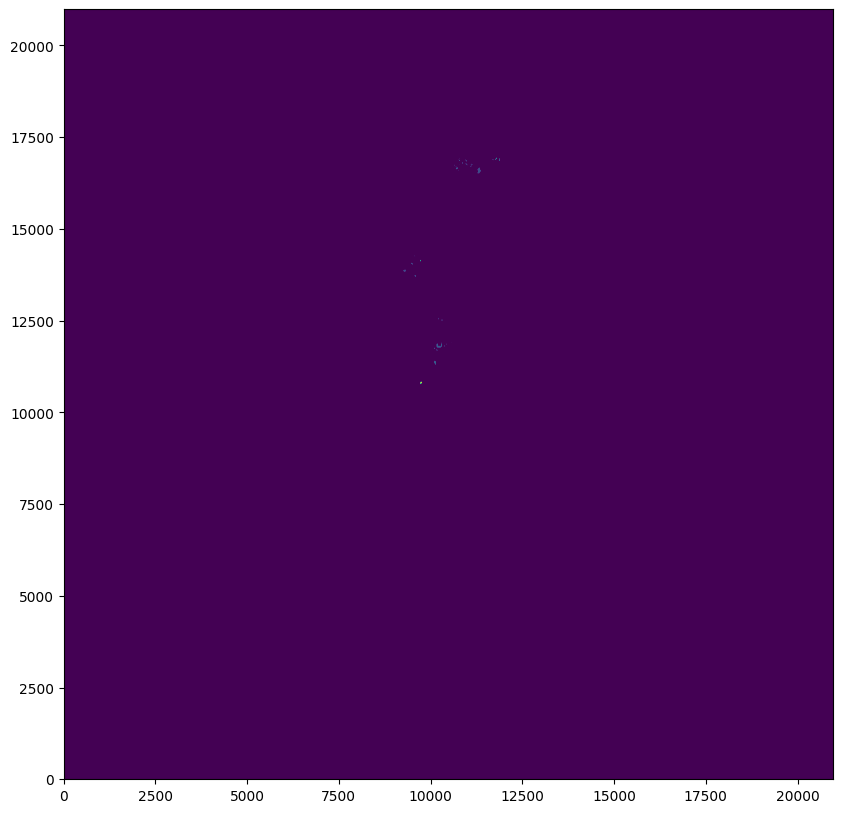

In [251]:
fig, ax = plt.subplots(1, figsize=(10, 10))
rio.plot.show(
    rasterized,
    ax=ax,
)
plt.gca().invert_yaxis()

In [253]:
# now make y the rasterized array
y = rasterized.reshape(-1)

In [254]:
# fit the model
rf.fit(X, y)